In [2]:
import datetime, warnings, scipy
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
import pickle
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")
import os
os.environ["PROJ_LIB"] = os.path.join(os.environ["CONDA_PREFIX"], "share", "proj")

In [3]:
df = pd.read_csv('data/flights_2019_jan_raw.csv', low_memory=False)
airports = pd.read_csv("airports.csv")

In [4]:
df.fl_date.describe()

count         638649
unique            31
top       2019-01-02
freq           22311
Name: fl_date, dtype: object

In [5]:
df.fl_date = pd.to_datetime(df.fl_date)

In [6]:
df.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,diverted,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2019-01-01,WN,WN,WN,2054,WN,N281WN,2054,13198,MCI,"Kansas City, MO",11259,DAL,"Dallas, TX",1535,1543.0,8.0,19.0,1602.0,1720.0,3.0,1705,1723.0,18.0,0.0,NaN,0.0,N,90.0,100.0,78.0,1.0,461.0,8.0,0.0,10.0,0.0,0.0,NaN,NaN,NaN,NaN
1,2019-01-01,WN,WN,WN,2139,WN,N929WN,2139,13198,MCI,"Kansas City, MO",11259,DAL,"Dallas, TX",1310,1316.0,6.0,6.0,1322.0,1443.0,3.0,1445,1446.0,1.0,0.0,NaN,0.0,N,95.0,90.0,81.0,1.0,461.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01,WN,WN,WN,1686,WN,N7869A,1686,13198,MCI,"Kansas City, MO",11278,DCA,"Washington, DC",1825,1830.0,5.0,20.0,1850.0,2131.0,31.0,2140,2202.0,22.0,0.0,NaN,0.0,N,135.0,152.0,101.0,1.0,949.0,0.0,0.0,22.0,0.0,0.0,NaN,NaN,NaN,NaN
3,2019-01-01,WN,WN,WN,2232,WN,N8551Q,2232,13198,MCI,"Kansas City, MO",11278,DCA,"Washington, DC",835,833.0,-2.0,9.0,842.0,1126.0,10.0,1150,1136.0,-14.0,0.0,NaN,0.0,N,135.0,123.0,104.0,1.0,949.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01,WN,WN,WN,677,WN,N709SW,677,13198,MCI,"Kansas City, MO",11292,DEN,"Denver, CO",1845,1854.0,9.0,22.0,1916.0,1947.0,8.0,1930,1955.0,25.0,0.0,NaN,0.0,N,105.0,121.0,91.0,1.0,533.0,9.0,0.0,16.0,0.0,0.0,NaN,NaN,NaN,NaN


In [7]:
df.op_unique_carrier.unique() # don't have US and VX, keep YX and OH

array(['WN', 'AS', 'YX', 'YV', 'EV', '9E', 'G4', 'NK', 'AA', 'PT', 'MQ',
       'OH', 'HA', 'EM', 'DL', 'B6', 'CP', 'OO', 'QX', 'F9', 'C5', 'ZW',
       'AX', 'G7', 'UA', 'KS'], dtype=object)

In [8]:
rid_airlines = ['KS','EM','C5','AX','G4','G7','ZW','CP','9E','YV','QX','PT']

In [9]:
df = df[~df.op_unique_carrier.isin(rid_airlines)]

In [10]:
df.op_unique_carrier.unique()

array(['WN', 'AS', 'YX', 'EV', 'NK', 'AA', 'MQ', 'OH', 'HA', 'DL', 'B6',
       'OO', 'F9', 'UA'], dtype=object)

In [11]:
df.rename(columns={
    'fl_date': 'DATE',
    'op_unique_carrier': 'AIRLINE',
    'op_carrier_fl_num': 'FLIGHT_NUMBER',
    'tail_num': 'TAIL_NUMBER',
    'origin': 'ORIGIN_AIRPORT',
    'dest_airport_id': 'DESTINATION_AIRPORT',
    'dep_time': 'DEPARTURE_TIME',
    'dep_delay': 'DEPARTURE_DELAY',
    'taxi_out': 'TAXI_OUT',
    'wheels_off': 'WHEELS_OFF',
    'crs_dep_time': 'SCHEDULED_TIME',
    'crs_dep_time': 'SCHEDULED_DEPARTURE',
    'crs_elapsed_time': 'ELAPSED_TIME',
    'air_time': 'AIR_TIME',
    'distance': 'DISTANCE',
    'wheels_on': 'WHEELS_ON',
    'taxi_in': 'TAXI_IN',
    'crs_arr_time': 'SCHEDULED_ARRIVAL',
    'arr_time': 'ARRIVAL_TIME',
    'arr_delay': 'ARRIVAL_DELAY',
    'diverted': 'DIVERTED',
    'cancelled': 'CANCELLED',
    'cancellation_code': 'CANCELLATION_REASON',
    'nas_delay': 'AIR_SYSTEM_DELAY',
    'security_delay': 'SECURITY_DELAY',
    'carrier_delay': 'AIRLINE_DELAY',
    'late_aircraft_delay': 'LATE_AIRCRAFT_DELAY',
    'weather_delay': 'WEATHER_DELAY',
    'fl_date': 'DATE' 
}, inplace=True)

In [12]:
# convert the format
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure
def combine_date_heure(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])
def create_flight_time(df, col):    
    liste = []
    for index, cols in df[['DATE', col]].iterrows():    
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_heure(cols))
        else:
            cols[1] = format_heure(cols[1])
            liste.append(combine_date_heure(cols))
    return pd.Series(liste)

### important datetime modifications

In [13]:
# modify variables
df['SCHEDULED_DEPARTURE'] = create_flight_time(df, 'SCHEDULED_DEPARTURE')
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_heure)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_heure)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_heure)
#__________________________________________________________________________
df.loc[:5, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME',
             'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,ARRIVAL_TIME,DEPARTURE_DELAY,ARRIVAL_DELAY
0,2019-01-01 15:35:00,17:05:00,15:43:00,17:23:00,8.0,18.0
1,2019-01-01 13:10:00,14:45:00,13:16:00,14:46:00,6.0,1.0
2,2019-01-01 18:25:00,21:40:00,18:30:00,22:02:00,5.0,22.0
3,2019-01-01 08:35:00,11:50:00,08:33:00,11:36:00,-2.0,-14.0
4,2019-01-01 18:45:00,19:30:00,18:54:00,19:55:00,9.0,25.0
5,2019-01-01 06:20:00,07:10:00,06:23:00,07:28:00,3.0,18.0


In [14]:
# filling factors
variables_to_remove = ['TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'DATE', 'AIR_SYSTEM_DELAY',
                       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
                       'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
                       'FLIGHT_NUMBER', 'TAIL_NUMBER', 'AIR_TIME']
df.drop(variables_to_remove, axis = 1, inplace = True)
df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
        'ELAPSED_TIME']]

In [15]:
# examing the missing value
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,SCHEDULED_DEPARTURE,85386,84.149767
1,ARRIVAL_DELAY,16861,96.870087
2,ARRIVAL_TIME,15978,97.033998
3,DEPARTURE_DELAY,15318,97.156514
4,DEPARTURE_TIME,15317,97.156700
5,ELAPSED_TIME,7,99.998701
6,AIRLINE,0,100.000000
7,ORIGIN_AIRPORT,0,100.000000
8,DESTINATION_AIRPORT,0,100.000000
9,SCHEDULED_ARRIVAL,0,100.000000


In [16]:
# remove missing values
df.dropna(inplace = True)

In [17]:
airlines_names = pd.read_csv('airlines.csv')
airlines_names

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,OH,PSA Airlines
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [18]:
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()

In [19]:
# compute parameters
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
global_stats = df['DEPARTURE_DELAY'].groupby(df['AIRLINE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean
AIRLINE,,,,
HA,-23.0,528.0,5712.0,1.782913
F9,-31.0,1022.0,8039.0,11.475059
EV,-29.0,1332.0,10491.0,14.625298
NK,-46.0,1434.0,13034.0,7.273285
AS,-47.0,521.0,16953.0,4.383472
OH,-25.0,1157.0,19077.0,6.538607
B6,-31.0,1315.0,19490.0,20.307029
MQ,-29.0,983.0,20903.0,9.001770
YX,-23.0,1077.0,21075.0,10.755777


In [20]:
df.head()

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,ELAPSED_TIME
0,WN,MCI,11259,2019-01-01 15:35:00,15:43:00,8.0,17:05:00,17:23:00,18.0,90.0
1,WN,MCI,11259,2019-01-01 13:10:00,13:16:00,6.0,14:45:00,14:46:00,1.0,95.0
2,WN,MCI,11278,2019-01-01 18:25:00,18:30:00,5.0,21:40:00,22:02:00,22.0,135.0
3,WN,MCI,11278,2019-01-01 08:35:00,08:33:00,-2.0,11:50:00,11:36:00,-14.0,135.0
4,WN,MCI,11292,2019-01-01 18:45:00,18:54:00,9.0,19:30:00,19:55:00,25.0,105.0


In [21]:
# Graphics?

In [22]:
import matplotlib.patches as mpatches

df2 = df.loc[:, ['AIRLINE', 'DEPARTURE_DELAY']]
df2['AIRLINE'] = df2['AIRLINE'].replace(abbr_companies)

In [23]:
# Create delay level column
delay_type = lambda x:((0,1)[x > 5],2)[x > 30]
df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(delay_type)

In [24]:
origin_nb = dict()
for carrier in abbr_companies.keys():
    list_origin_airport = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
    origin_nb[carrier] = len(list_origin_airport)

In [25]:
test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)

In [26]:
temp = pd.read_csv('airports.csv')
identify_airport = temp.set_index('IATA_CODE')['CITY'].to_dict()
latitude_airport = temp.set_index('IATA_CODE')['LATITUDE'].to_dict()
longitude_airport = temp.set_index('IATA_CODE')['LONGITUDE'].to_dict()

In [27]:
airport_mean_delays = pd.DataFrame(pd.Series(df['ORIGIN_AIRPORT'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)

for carrier in abbr_companies.keys():
    df1 = df[df['AIRLINE'] == carrier]
    test = df1['DEPARTURE_DELAY'].groupby(df['ORIGIN_AIRPORT']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean']

In [28]:
# Make class/functions for plotting with training/testing
# Googled this, took forever

class Figure_style():
    def __init__(self, size_x = 11, size_y = 5, nrows = 1, ncols = 1):
        sns.set_style("white")
        sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
        self.fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize=(size_x,size_y,))
        if nrows == 1 and ncols == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif nrows == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif ncols == 1:
            self.axs = np.reshape(axs, (-1, 1))
    def pos_update(self, ix, iy):
        self.ix, self.iy = ix, iy
    def style(self):
        self.axs[self.ix, self.iy].spines['right'].set_visible(False)
        self.axs[self.ix, self.iy].spines['top'].set_visible(False)
        self.axs[self.ix, self.iy].yaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].xaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].tick_params(axis='both', which='major',
                                               labelsize=10, size = 5)
    def draw_legend(self, location='upper right'):
        legend = self.axs[self.ix, self.iy].legend(loc = location, shadow=True,
                                        facecolor = 'g', frameon = True)
        legend.get_frame().set_facecolor('whitesmoke')
    def cust_plot(self, x, y, color='orangered', linestyle='-', linewidth=1, marker=None, label=''):
        if marker:
            markerfacecolor, marker, markersize = marker[:]
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                linewidth = linewidth, marker = marker, label = label,
                                markerfacecolor = markerfacecolor, markersize = markersize)
        else:
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                        linewidth = linewidth, label=label)
        self.fig.autofmt_xdate()
    def cust_plot_date(self, x, y, color='orangered', linestyle='-',
                       linewidth=1, markeredge=False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].plot_date(x, y, color='lightblue', markeredgecolor='grey',
                                  markeredgewidth = markeredgewidth, label=label)
    def cust_scatter(self, x, y, color = 'lightblue', markeredge = False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].scatter(x, y, color=color,  edgecolor='grey',
                                  linewidths = markeredgewidth, label=label)    
    def set_xlabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_xlabel(label, fontsize = fontsize)
    def set_ylabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_ylabel(label, fontsize = fontsize)
    def set_xlim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_xlim([lim_inf, lim_sup])
    def set_ylim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_ylim([lim_inf, lim_sup])

In [29]:
# Southwest Airlines 
carrier = 'WN'
# Phoenix Sky Harbor International Airport (PHX)
id_airport = 4
list_origin_airport = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
df2 = df[(df['AIRLINE'] == carrier) & (df['ARRIVAL_DELAY'] > 0)
         & (df['ORIGIN_AIRPORT'] == list_origin_airport[id_airport])]
df2.sort_values('SCHEDULED_DEPARTURE', inplace = True) # SCHEDULED_DEPARTURE WRONG

In [30]:
df3 = df2.copy() # checkpoint

In [31]:
df3.head()

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,ELAPSED_TIME,DELAY_LEVEL
408,WN,MHT,13232,2019-01-01 05:45:00,05:42:00,-3.0,07:20:00,07:56:00,36.0,155.0,0
407,WN,MHT,13232,2019-01-01 13:20:00,13:15:00,-5.0,14:50:00,15:15:00,25.0,150.0,0
409,WN,MHT,13232,2019-01-01 16:15:00,16:14:00,-1.0,17:50:00,18:14:00,24.0,155.0,0
404,WN,MHT,10821,2019-01-01 16:40:00,17:25:00,45.0,18:10:00,18:54:00,44.0,90.0,2
406,WN,MHT,13204,2019-01-01 17:45:00,18:30:00,45.0,21:00:00,21:55:00,55.0,195.0,2


In [32]:
def func2(x, a, b, c):
    return a * x**2 +  b*x + c
df2['TIME_DEPARTURE'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
test2 = df2['DEPARTURE_DELAY'].groupby(df2['TIME_DEPARTURE']).apply(get_stats).unstack()
fct = lambda x:x.hour*3600+x.minute*60+x.second
x_val = np.array([fct(s) for s in test2.index]) 
y_val = test2['mean']
popt, pcov = curve_fit(func2, x_val, y_val, p0 = [1, 2, 3])
test2['fit'] = pd.Series(func2(x_val, *popt), index = test2.index)

# start training

In [33]:
df.head()

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,ELAPSED_TIME,DELAY_LEVEL
0,WN,MCI,11259,2019-01-01 15:35:00,15:43:00,8.0,17:05:00,17:23:00,18.0,90.0,1
1,WN,MCI,11259,2019-01-01 13:10:00,13:16:00,6.0,14:45:00,14:46:00,1.0,95.0,1
2,WN,MCI,11278,2019-01-01 18:25:00,18:30:00,5.0,21:40:00,22:02:00,22.0,135.0,0
3,WN,MCI,11278,2019-01-01 08:35:00,08:33:00,-2.0,11:50:00,11:36:00,-14.0,135.0,0
4,WN,MCI,11292,2019-01-01 18:45:00,18:54:00,9.0,19:30:00,19:55:00,25.0,105.0,1


In [34]:
df2.head()

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,ELAPSED_TIME,DELAY_LEVEL,TIME_DEPARTURE
408,WN,MHT,13232,2019-01-01 05:45:00,05:42:00,-3.0,07:20:00,07:56:00,36.0,155.0,0,05:45:00
407,WN,MHT,13232,2019-01-01 13:20:00,13:15:00,-5.0,14:50:00,15:15:00,25.0,150.0,0,13:20:00
409,WN,MHT,13232,2019-01-01 16:15:00,16:14:00,-1.0,17:50:00,18:14:00,24.0,155.0,0,16:15:00
404,WN,MHT,10821,2019-01-01 16:40:00,17:25:00,45.0,18:10:00,18:54:00,44.0,90.0,2,16:40:00
406,WN,MHT,13204,2019-01-01 17:45:00,18:30:00,45.0,21:00:00,21:55:00,55.0,195.0,2,17:45:00


In [35]:
train_pct_index = int(0.8 * len(df2))
df_train, df_test = df2[:train_pct_index], df2[train_pct_index:]

In [36]:
df = df_train

In [37]:
df.DELAY_LEVEL.unique() # our cheat

array([0, 2, 1])

In [38]:
carrier = 'AA'
check_airports = df[(df['AIRLINE'] == carrier)]['DEPARTURE_DELAY'].groupby(
                         df['ORIGIN_AIRPORT']).apply(get_stats).unstack()
check_airports.sort_values('count', ascending = False, inplace = True)
check_airports[-5:]

ValueError: index must be a MultiIndex to unstack, <class 'pandas.core.indexes.base.Index'> was passed

In [42]:
# Googled functions and fit our data

In [39]:
def get_flight_delays(df, carrier, id_airport, extrem_values = False):
    df2 = df[(df['AIRLINE'] == carrier) & (df['ORIGIN_AIRPORT'] == id_airport)]
    if extrem_values:
        df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
        df2.dropna(how = 'any')
    df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)
    df2['heure_depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
    test2 = df2['DEPARTURE_DELAY'].groupby(df2['heure_depart']).apply(get_stats).unstack()
    test2.reset_index(inplace=True)
    fct = lambda x:x.hour*3600+x.minute*60+x.second
    test2.reset_index(inplace=True)
    test2['heure_depart_min'] = test2['heure_depart'].apply(fct)
    return test2

In [40]:
def linear_regression(test2):
    test = test2[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)
    X = np.array(test['heure_depart_min'])
    Y = np.array(test['mean'])
    X = X.reshape(len(X),1)
    Y = Y.reshape(len(Y),1)
    regr = linear_model.LinearRegression()
    regr.fit(X, Y)
    result = regr.predict(X)
    return X, Y, result

In [41]:
class fit_polynome:

    def __init__(self, data):
        self.data = data[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)

    def split(self, method):        
        self.method = method        
        self.X = np.array(self.data['heure_depart_min'])
        self.Y = np.array(self.data['mean'])
        self.X = self.X.reshape(len(self.X),1)
        self.Y = self.Y.reshape(len(self.Y),1)

        if method == 'all':
            self.X_train = self.X
            self.Y_train = self.Y
            self.X_test  = self.X
            self.Y_test  = self.Y                        
        elif method == 'split':            
            self.X_train, self.X_test, self.Y_train, self.Y_test = \
                train_test_split(self.X, self.Y, test_size=0.3)
    
    def train(self, pol_order):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X_train)
        self.regr.fit(self.X_, self.Y_train)
    
    def predict(self, X):
        self.X_ = self.poly.fit_transform(X)
        self.result = self.regr.predict(self.X_)
    
    def calc_score(self):        
        X_ = self.poly.fit_transform(self.X_test)
        result = self.regr.predict(X_)
        self.score = metrics.mean_squared_error(result, self.Y_test)

ValueError: index must be a MultiIndex to unstack, <class 'pandas.core.indexes.datetimes.DatetimeIndex'> was passed

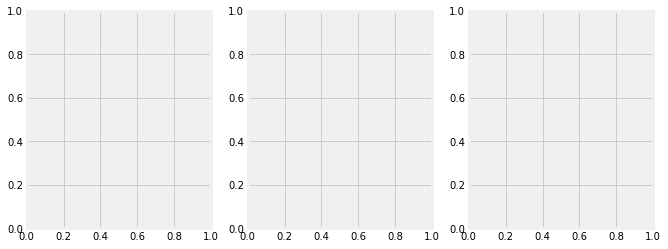

In [43]:
fig = plt.figure(1, figsize=(10,4))

ax = ['_' for _ in range(4)]
ax[1]=fig.add_subplot(131) 
ax[2]=fig.add_subplot(132) 
ax[3]=fig.add_subplot(133) 

id_airport = 'BNA'
test2 = get_flight_delays(df, carrier, id_airport, True)

result = ['_' for _ in range(4)]
score = [10000 for _ in range(4)]
found = [False for _ in range(4)]
fit = fit_polynome(test2)

color = '.rgbyc'

inc = 0
while True:
    inc += 1
    fit.split('split')
    for i in range(1,4):
        fit.train(pol_order = i)
        fit.predict(fit.X)
        result[i] = fit.result
        fit.calc_score()
        score[i]  = fit.score

    [ind_min] = [j for j,val in enumerate(score) if min(score) == val]
    print("No:{:<2}, n = {}, score = {:.1f}".format(inc, ind_min,score[ind_min]))
    
    if not found[ind_min]:            
        for i in range(1,4):
            ax[ind_min].plot(fit.X, result[i], color[i], linewidth = 4 if i == ind_min else 1)
        ax[ind_min].scatter(fit.X, fit.Y)                
        ax[ind_min].text(0.05, 0.95, 'MSE = {:.1f}, {:.1f}, {:.1f}'.format(*score[1:4]),
                         style='italic', transform=ax[ind_min].transAxes, fontsize = 8,
                         bbox={'facecolor':'blue', 'alpha':0.5, 'pad':5})                
        found[ind_min] = True

    shift = 0.5
    plt.text(-1+shift, 1.05, "polynomial order:", color = 'k',
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
    plt.text(0+shift, 1.05, "n = 1", color = 'k', 
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
    plt.text(0.4+shift, 1.05, "n = 2", color = 'k', 
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
    plt.text(0.8+shift, 1.05, "n = 3", color = 'k',
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
   
    if inc == 40 or all(found[1:4]): break